In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

In [4]:
def TestData(mean=[2,-4], var=[1,1], n=20, skips=3):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

adding a new state at: -6.2759607708
resampling
adding a new state at: -1.34979003541
resampling
adding a new state at: 3.0521868935
resampling
resampling
resampling


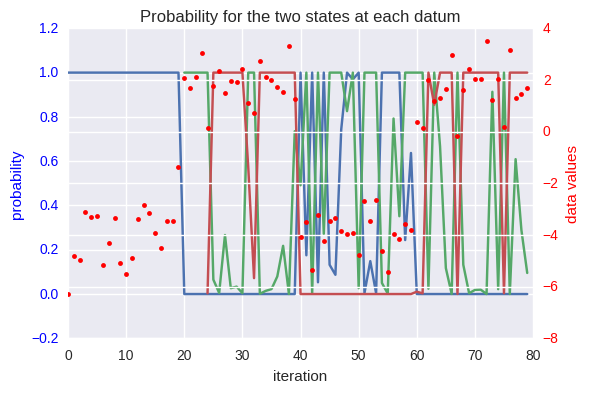

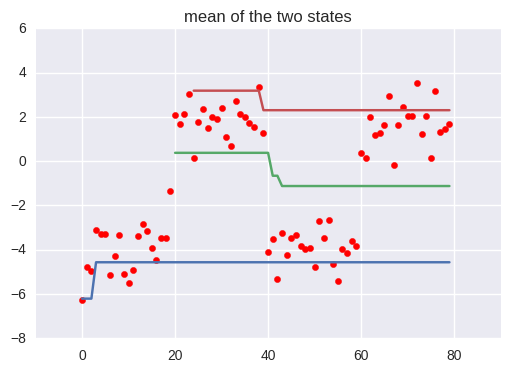

In [10]:
d = TestData()
cp = MultiStateChangePointDetection(BootstrapFilter)
z,m = cp.run(d)
plotMultiStateParticle(d, z, m)

In [6]:
def plotMultiStateParticle(data, z, m ):
################ PREPARE DATA ################     
    states = 0
    zData = []
    meanData = []
    varData = []
    for t,z_t in enumerate(z):
        if len(z_t)>states:
            states += 1
            zData.append(([],range(t,len(data))))
            meanData.append(([],range(t,len(data))))
            varData.append(([],range(t,len(data))))
        for i,z_t_i in enumerate(z_t):
            zData[i][0].append(z_t_i)
            #print m[t]
            meanData[i][0].append(m[t][i])
################ PLOT Z ################ 
    fig, ax1 = plt.subplots()
    ax1.set_ylim([-0.2,1.2])
    for z in zData: 
        ax1.plot(z[1], z[0])
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('probability', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(range(0,len(data)), data, 'r.')
    ax2.set_ylabel('data values', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Probability for the two states at each datum")
    plt.show()
################ PLOT MEAN ################     
    for m in meanData:
        plt.plot(m[1], m[0])
    plt.scatter(range(0,len(data)),data, color='red')
    plt.title('mean of the two states')
    plt.show()

In [11]:
class MultiStateChangePointDetection(object):
    beta = 0.001
    def __init__(self, cls, states=0):
        self.cls = cls
        self.f = []
        self.data = []
        for s in range(states):
            p = np.random.normal(np.random.uniform(low=-5, high=5), size=200, var=4)
            self.f.append(self.cls(particles=p))
        
    def update(self,_x):
        if len(self.f)<1:
            self.addState(_x)
        likelihood = []
        for f in self.f:
            l = scipy.stats.norm(f.mean, f.var).pdf(_x)
            likelihood.append(l[0])

        indexMaxL = likelihood.index(max(likelihood))
        if(max(likelihood)<self.beta):#this could work better with outlier detection
            indexMaxL = self.addState(_x)
        self.f[indexMaxL].update(_x)
        mean = []
        var = []
        for f in self.f:
            mean.append(f.mean[-1])
            var.append(f.var[-1])
        return [l/max(likelihood) for l in likelihood], mean, var
    
    def addState(self, _x):
        print 'adding a new state at: '+str(_x)
        p = np.random.normal(_x, size=200)
        self.f.append(self.cls(particles=p))
        return len(self.f)-1
    
    def run(self, data):
        particles = []
        z = []
        mean = []
        var = []
        for i, d in enumerate(data):
            l, m, v = self.update(d)        
            z.append(list(l))
            mean.append(list(m))
            #var.append((list(v),i))
        return z, mean

## Bootstrap Filter

In [12]:
class BootstrapFilter(object):
    
    def __init__(self, d=1, likelihood=(0,1), prior=(-5,5), N=200, \
                 noise = 0.1, particles=None):
        self.dimension = d
        self.prior = prior
        self.noise = noise
        self.likelihood = likelihood
        
        if particles is not None:
            self.particles = particles
            self.weights = np.ones(len(self.particles))
        else:           
            #particles are drawn form a uniform square
            self.particles = np.random.uniform(low=prior[0], high=prior[1],\
                                               size=(N,d))
            self.weights = np.ones(N)
        self.mean = [np.mean(self.particles)]
        self.var = [np.var(self.particles)]
        
    def update(self, datum, a=1):
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(datum, \
                    self.likelihood[1]).pdf(self.particles[i]) * a      
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        #mean = np.average(self.particles, weights=self.weights, axis=0)[0]       
        if 1. / np.sum(np.square(self.weights)) < len(self.weights) / 2:            
            self.multinomialResampling()
            print 'resampling'
        else:
            #print 'no resampling'
            pass
        mean = np.mean(self.particles)
        self.mean.append(mean)
        self.var.append(np.var(self.particles)) 
        return self.particles, self.weights
        
    def markovTransition(self, p):
        return p #+ np.random.normal(0,self.noise)
        
    def multinomialResampling(self):
        N = len(self.weights)
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1
        uniform = np.random.uniform(size=N)
        indexes = np.searchsorted(cumsum, uniform)
        # resample according to indexes
        self.particles = self.particles[indexes]
        self.weights.fill(1.0 / N)
        

## Opper

In [13]:
class OpperMAPSimple(object):
    
    def __init__(self, theta):
        self.theta = [theta,1.1]
        self.likelihoodParams0 = [self.theta[0],1]
        
    def computeTheta(self, _x, _theta):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + 1) * (_x + theta[0]/theta[1])
        return theta
    
    def computeIntegral(self, _x, _theta): # it assumes the wrong var for now
        exp = np.exp( (_x + _theta[0])**2/4 - (_x**2-_theta[0]**2)/2 )
        return np.sqrt(np.pi)/(2*np.pi) * exp
    
    def update(self, _x): 
        likelihood = scipy.stats.norm(self.likelihoodParams[0], self.likelihoodParams[1]).pdf(_x)       
        w = 1 # TODO self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]       
        integral = self.computeIntegral(_x, self.theta)        
        z = w * integral
        self.theta = self.computeTheta(_x, self.theta)
        self.likelihoodParams[0] = self.theta[0]
        
        return self.z, self.theta[0], self.theta[1]

In [14]:
d = TestData()
cp = MultiStateChangePointDetection(OpperMAPSimple)
z,m = cp.run(d)
plotMultiStateParticle(d, z, m)

adding a new state at: -3.95913464054


TypeError: __init__() got an unexpected keyword argument 'particles'